# I. INTRODUCTION
- NAME    : DANIYAL KAHFI
- BATCH   : RMT-029
- OBJECT  : MEMBUAT MODEL NLP DENGAN KONTEKS SENTIMEN ANALISIS DARI KOMENTAR DI IMDB

# II. IMPORT LIBRARIES





In [1]:
# Import Libraries

import requests
import zipfile
import io
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as tf_hub
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# DATA LOADING

In [2]:
# URL GitHub dari file ZIP
url = 'https://github.com/DaniyalKahfi/NLP_Dataset/raw/main/archive.zip'

# Mengunduh file ZIP
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# Mengekstrak file CSV
z.extractall('/content/extracted')

# Membuat Dataframe
df = pd.read_csv('/content/extracted/movie.csv')

df

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


Terdapat 40000 rows dan 2 kolom yang berisikan teks dan label sentimennya.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [4]:
# Data Duplicates Check
print("Amount of duplicate data: ", df.duplicated().sum())

Amount of duplicate data:  277


Terdapat 277 data duplikat pada dataset. Akan dilakukan penghapusan data duplikat untuk menghindari hasil model yang kurang baik.

In [5]:
df.drop_duplicates()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


Setelah melakukan drop duplikat, tersisa 39723 rows dan 2 kolom.

In [6]:
unique_values = df['text'].unique()
print(unique_values)


['I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.'
 "When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping t

In [7]:
# Memeriksa nilai NaN dalam kolom 'text'
print("NaN values in 'text' column:")
print(df['text'].isna().sum())

# Memeriksa nilai NaN dalam kolom 'label'
print("\nNaN values in 'label' column:")
print(df['label'].isna().sum())


NaN values in 'text' column:
0

NaN values in 'label' column:
0


Tidak terdapat NaN value

# III. EXPLORATORY DATA ANALYSIS

### 3.1 The Most Frequent Word

In [8]:
df['text'].mode()


0    Hilarious, clean, light-hearted, and quote-wor...
1    Loved today's show!!! It was a variety and not...
Name: text, dtype: object

In [9]:
df['label'].mode()

0    0
Name: label, dtype: int64

### 3.2 Word Count

In [10]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

In [11]:
def plot_target_hist(df, col):
    outcome_counts = df[col].value_counts()
    total = outcome_counts.sum()
    outcome_percentages = outcome_counts / total * 100

    out_hist = outcome_counts.plot(kind='bar', figsize=(3.5, 3.5))
    plt.xticks(rotation=0, fontsize=9)
    plt.yticks(range(0, max(outcome_counts) + 1, 5000), fontsize=9)
    plt.xlabel(None)

    for i, percentage in enumerate(outcome_percentages):
        plt.text(i, outcome_counts[i], f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)

    plt.show()

In [12]:
def plot_col_hist(df, col):
    plt.figure(figsize=(14, 3.5))
    plt.hist(df[df['label'] == 1][col], bins=50, alpha=0.6, color='#1F77B4', label='1')
    plt.hist(df[df['label'] == 0][col], bins=50, alpha=0.6, color='#D62728', label='0')
    plt.tick_params(labelsize=9)
    plt.xticks(range(0, max(df[col])+1, 250))
    plt.legend(fontsize=8)
    plt.show()

In [13]:
def plot_word_cloud(df, lbl):
    figsize=(14.7, 7.35)

    text = ' '.join(df[df['label'] == lbl]['text'])
    wordcloud = WordCloud(width=int(figsize[0]*100), height=int(figsize[1]*100), background_color='black').generate(text)

    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

#### 3.2.1 Data Balance Check

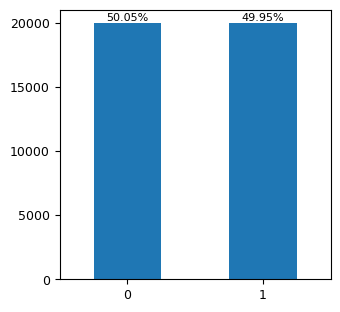

In [14]:
### Univariate Analysis
plot_target_hist(df, 'label')

Kita dapat menyimpulkan bahwa data memiliki class yang seimbang/ balance data

#### 3.2.2 Comparison Number of Words by Class

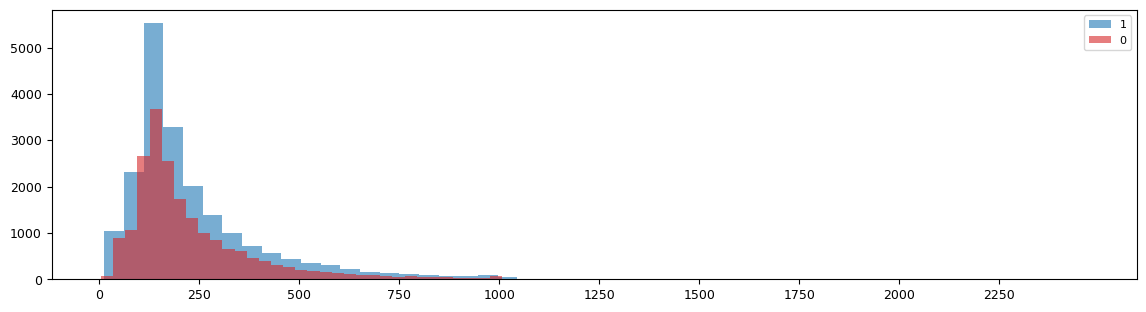

In [15]:
### Multivariate Analysis
plot_col_hist(df, 'word_count')

Plot diatas menjelaskan istribusi word_count untuk setiap nilai dalam kolom target. Kita dapat melihat distribusi kata dalam setiap class 1 dan 0. Terlihat bahwa class 1 memiliki kata lebih banyak dibanding 0.

#### 3.2.3 Word Cloud

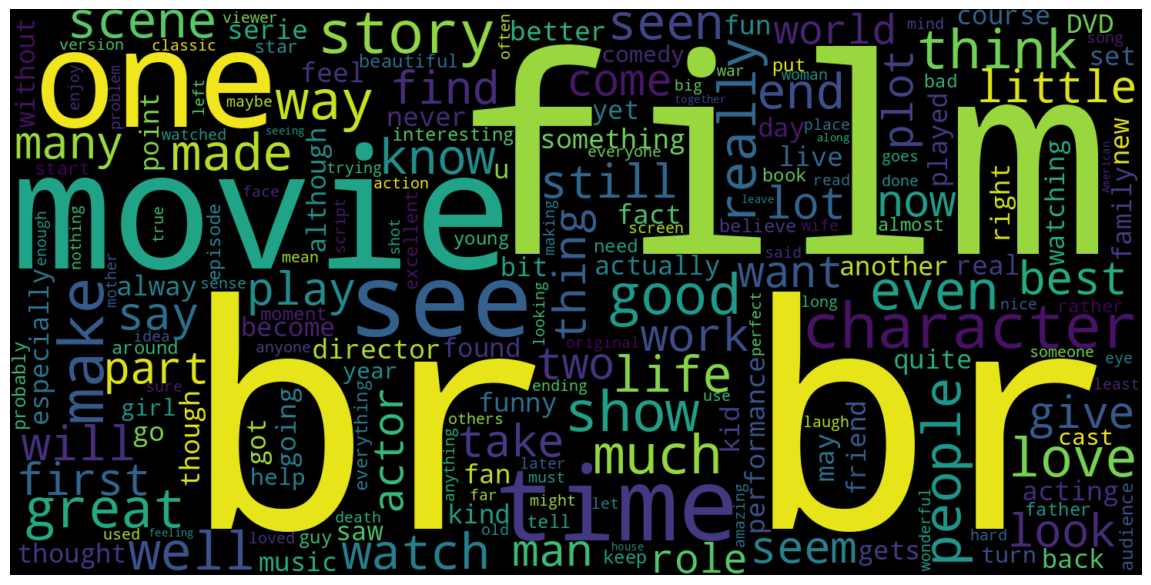

In [16]:
plot_word_cloud(df, 1)

Hasil word cloud dapat membantu Anda memahami tema atau topik utama dari teks tersebut. Dari hasil diatas bahwa topik bahasannya mengenai review film yang membahas waktu (time), film, dan lainnya. Berdasarkan 'Human Feelings' terlihat bahwa class 1 membahas mengenai sentimen positif dari film yang disaksikan.

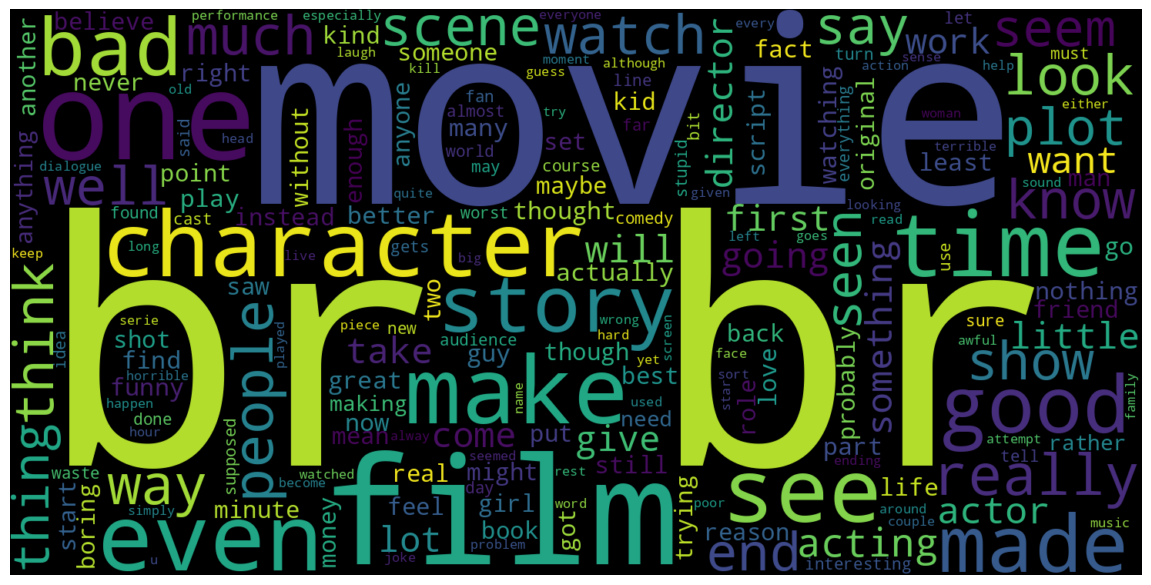

In [17]:
plot_word_cloud(df, 0)

Sama seperti sebelumnya, dari gambar diatas kita dapat mengetahui topik atau inti sebuah bahasan pada data text class 0

# IV. TEXT PROCESSING

In [18]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# Inisialisasi stopwords
stpwds_id = set(stopwords.words('english'))

# Inisialisasi stemming
stemmer = PorterStemmer()

In [20]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [21]:
def preprocess_data(text):
    stopwords_set = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stopwords_set)

    lemma = WordNetLemmatizer()
    text = ' '.join(lemma.lemmatize(word) for word in text.split())

    text = ' '.join(word for word in text.split() if len(word) > 2)
    return text

In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Dari personal judgement, wordnet cocok digunakan untuk clean text karena text yang diolah menggunakan Bahasa Inggris

In [23]:
df['clean_text'] = df['text'].apply(clean_text)
df['final_text'] = df['clean_text'].apply(preprocess_data)

In [24]:
df = df[['text', 'clean_text', 'final_text', 'label']]
pd.set_option('display.max_colwidth', None)
pd.DataFrame(df.iloc[1]).transpose()

,text,clean_text,final_text,label
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, but the animation in particular is a sad sight. The storyline is also pretty weak, as its more like three episodes of Schooby-Doo than the single adventurous story we got the last time. But dont misunderstand, it's not very good Schooby-Doo episodes. I didnt laugh a single time, although I might have sniggered once or twice.<br /><br />To the audience who haven't seen the first movie, or don't especially care for a similar sequel, here is a fast review of this movie as a stand-alone product: If you liked schooby-doo, you might like this movie. If you didn't, you could still enjoy this movie if you have nothing else to do. And I suspect it might be a good kids movie, but I wouldn't know. It might have been better if Milo's Return had been a three-episode series on a cartoon channel, or on breakfast TV.",when i put this movie in my dvd player and sat down with a coke and some chips i had some expectations i was hoping that this movie would contain some of the strongpoints of the first movie awsome animation good flowing story excellent voice cast funny comedy and a kickass soundtrack but to my disappointment not any of this is to be found in atlantis milos return had i read some reviews first i might not have been so let down the following paragraph will be directed to those who have seen the first movie and who enjoyed it primarily for the points mentionedwhen the first scene appears your in for a shock if you just picked atlantis milos return from the displaycase at your local videoshop or whatever and had the expectations i had the music feels as a bad imitation of the first movie and the voice cast has been replaced by a not so fitting one with the exception of a few characters like the voice of sweet the actual drawings isnt that bad but the animation in particular is a sad sight the storyline is also pretty weak as its more like three episodes of schoobydoo than the single adventurous story we got the last time but dont misunderstand its not very good schoobydoo episodes i didnt laugh a single time although i might have sniggered once or twiceto the audience who havent seen the first movie or dont especially care for a similar sequel here is a fast review of this movie as a standalone product if you liked schoobydoo you might like this movie if you didnt you could still enjoy this movie if you have nothing else to do and i suspect it might be a good kids movie but i wouldnt know it might have been better if milos return had been a threeepisode series on a cartoon channel or on breakfast tv,put movie dvd player sat coke chip expectation hoping movie would contain strongpoints first movie awsome animation good flowing story excellent voice cast funny comedy kickass soundtrack disappointment found atlantis milo return read review first might let following paragraph directed seen first movie enjoyed primarily point mentionedwhen first scene appears shock picked atlantis milo return displaycase local videoshop w

# V. TARTGET CONVERTION

In [25]:
# Display Target

df.label.unique()

array([0, 1])

In [26]:
# Target Distribution

df['label'].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

In [27]:
# df Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df.final_text,
                                                    df.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (30600,)
Val Size   :  (3400,)
Test Size  :  (6000,)


In [28]:
# Change Target to One Hot Encoding

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# VI. MODEL BUILDING

### 6.1 Text Vectorization

In [29]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<30600x147174 sparse matrix of type '<class 'numpy.int64'>'
	with 2916600 stored elements in Compressed Sparse Row format>

In [30]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  147174
Maximum Sentence Length :  1385 tokens


Ada 147174 kata unik dalam dataset atau corpus yang digunakan untuk melakukan text vectorization. <br>
Panjang maksimum kalimat (atau teks) dalam data yang telah diolah adalah 1385 token. Ini berarti kalimat terpanjang dalam dataset memiliki panjang 1385 kata atau token. Ini akan berpengaruh saat melakukan padding

In [31]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

 Text Vectorization adalah pengubahan setiap kata dalam teks menjadi nilai numerik yang merepresentasikan kata tersebut.

In [32]:
# Example Result

## Document example
print('Document example')
print(df.final_text[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df.final_text[0]]))
print('Vector size : ', text_vectorization([df.final_text[0]]).shape)

Document example
grew watching loving thunderbird mate school watched played thunderbird school lunch school wanted virgil scott one wanted alan counting became art form took child see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbird thankfully early saturday morning one television channel still play rerun series gerry anderson wife created jonatha frakes hand director chair version completely hopeless waste film utter rubbish cgi remake may acceptable replacing marionette homo sapiens subsp sapiens huge error judgment

Result of Text Vectorization
tf.Tensor([[1766   65 1654 ...    0    0    0]], shape=(1, 1385), dtype=int64)
Vector size :  (1, 1385)


 Text Vectorization adalah pengubahan setiap kata dalam teks menjadi nilai numerik yang merepresentasikan kata tersebut.Teks telah diubah menjadi representasi numerik menggunakan metode seperti tokenization dan padding. Hasilnya adalah vektor dengan panjang 1385, yang merepresentasikan setiap kata dalam teks tersebut.<br>

In [33]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'movie',
 'film',
 'one',
 'like',
 'time',
 'good',
 'character',
 'get',
 'even',
 'story',
 'would',
 'make',
 'see',
 'really',
 'scene',
 'much',
 'well',
 'people']

List TOP 20 kata-kata diatas digunakan untuk mengonversi kata-kata menjadi representasi numerik dalam train model, sehingga model dapat memahami teks dalam bentuk vektor yang dapat diolah lebih lanjut.

### 6.2 Word Embedding

In [34]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [35]:
# Example Result

## Document example
print('Document example')
print(df.final_text[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df.final_text[0]]))
print('Vector size : ', text_vectorization([df.final_text[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df.final_text[0]])))
print('Vector size : ', embedding(text_vectorization([df.final_text[0]])).shape)

Document example
grew watching loving thunderbird mate school watched played thunderbird school lunch school wanted virgil scott one wanted alan counting became art form took child see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbird thankfully early saturday morning one television channel still play rerun series gerry anderson wife created jonatha frakes hand director chair version completely hopeless waste film utter rubbish cgi remake may acceptable replacing marionette homo sapiens subsp sapiens huge error judgment

Result of  Text Vectorization
tf.Tensor([[1766   65 1654 ...    0    0    0]], shape=(1, 1385), dtype=int64)
Vector size :  (1, 1385)

Result of  Embedding
tf.Tensor(
[[[ 0.02936367 -0.03887223 -0.04455426 ...  0.03999681 -0.0481236
   -0.04299773]
  [-0.03333955 -0.03467617 -0.04631112 ...  0.03365381  0.02710367
   -0.00045403]
  [-0.04113114 -0.04450544  0.03599473 ... -0.04593599 

Setiap kata dalam teks diubah menjadi vektor embedding yang memiliki panjang 128. Ini berarti setiap kata direpresentasikan oleh vektor 128 dimensi. Hasilnya adalah matriks dengan ukuran (1, 1385, 128), yang berisi vektor embedding untuk setiap kata dalam teks.

### 6.3 LSTM

Pada model training yang akan dilakukan, hanya dilakukan 10 epochs, dikarenakan durasi training yang mencapai 28 menit. Jika dilakukan lebih dari itu, akan memakan waktu yang sangat lama.

In [36]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(2, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=10, validation_data=(X_val, y_val_ohe))

Epoch 1/10
957/957 [==============================] - 254s 256ms/step - loss: 0.3690 - accuracy: 0.8406 - val_loss: 0.3200 - val_accuracy: 0.8747
Epoch 2/10
957/957 [==============================] - 176s 184ms/step - loss: 0.1425 - accuracy: 0.9508 - val_loss: 0.2999 - val_accuracy: 0.8794
Epoch 3/10
957/957 [==============================] - 167s 175ms/step - loss: 0.0620 - accuracy: 0.9807 - val_loss: 0.4106 - val_accuracy: 0.8703
Epoch 4/10
957/957 [==============================] - 164s 171ms/step - loss: 0.0605 - accuracy: 0.9803 - val_loss: 0.5446 - val_accuracy: 0.8647
Epoch 5/10
957/957 [==============================] - 162s 169ms/step - loss: 0.0967 - accuracy: 0.9670 - val_loss: 0.4911 - val_accuracy: 0.8726
Epoch 6/10
957/957 [==============================] - 159s 166ms/step - loss: 0.0213 - accuracy: 0.9939 - val_loss: 0.5529 - val_accuracy: 0.8656
Epoch 7/10
957/957 [==============================] - 155s 162ms/step - loss: 0.0120 - accuracy: 0.9962 - val_loss: 0.6034 -

Dari hasil train base model didapatkan score loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.7694 - val_accuracy: 0.8650. Hasil ini menunjukkan bahwa model mengalami overfitting, dimana hasil train jauh lebih baik dibandingkan hasil validationnya.

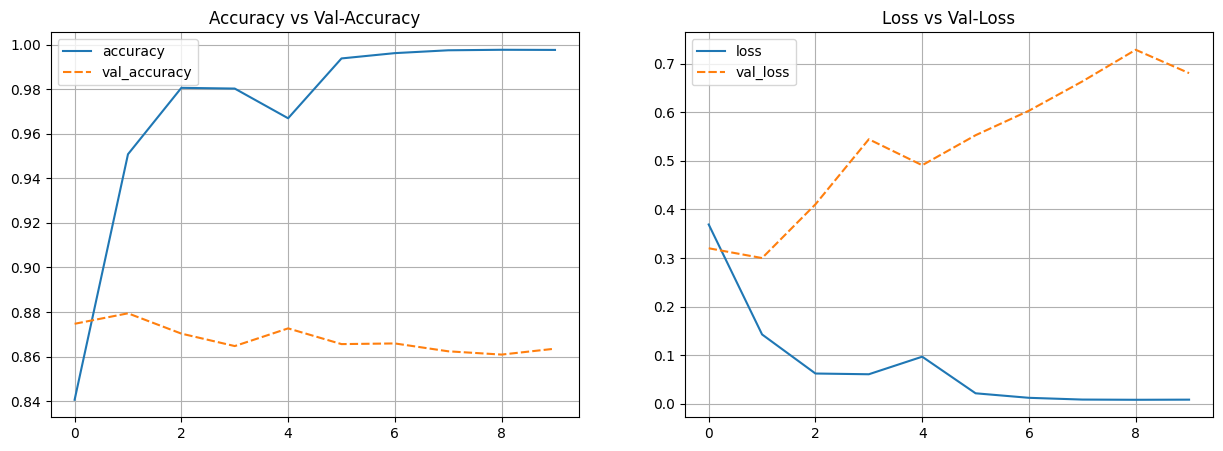

In [37]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

107/107 [==============================] - 9s 71ms/step


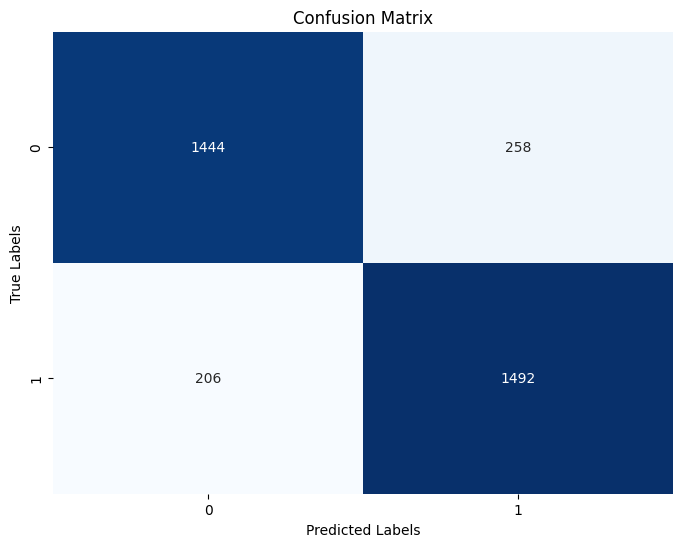

In [38]:
# Lakukan prediksi menggunakan model LSTM pada data validasi
predictions = model_lstm_1.predict(X_val)

# Konversi prediksi menjadi label kategori
predictions_categories = np.argmax(predictions, axis=1)

# Hitung confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_val_ohe, axis=1), predictions_categories)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Terlihat dari hasil confusion matrix bahwa base model dapat mengklasifikan data dengan baik. Base model dapat mengklasifikan 1429 dan 1512 data dengan benar, dan hanya mengalami kesalahan yang sedikit. Hal ini tentu sejalan dengan tujuan dibuatnya model yaitu dapat mengklasifikan data dengan baik.

## 6.4 LSTM with Transfer Learning

In [39]:
# Download the Embedding Layer

url = 'https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [40]:
# Model Training using LSTM with Transfer Learning
%%time
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(2, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_2_hist = model_lstm_2.fit(X_train, y_train_ohe, epochs=10, validation_data=(X_val, y_val_ohe))

Epoch 1/10
957/957 [==============================] - 32s 27ms/step - loss: 0.6925 - accuracy: 0.5159 - val_loss: 0.6885 - val_accuracy: 0.5547
Epoch 2/10
957/957 [==============================] - 24s 25ms/step - loss: 0.6775 - accuracy: 0.5671 - val_loss: 0.6598 - val_accuracy: 0.6006
Epoch 3/10
957/957 [==============================] - 24s 25ms/step - loss: 0.6520 - accuracy: 0.6175 - val_loss: 0.6454 - val_accuracy: 0.6265
Epoch 4/10
957/957 [==============================] - 24s 25ms/step - loss: 0.6392 - accuracy: 0.6342 - val_loss: 0.6350 - val_accuracy: 0.6318
Epoch 5/10
957/957 [==============================] - 24s 25ms/step - loss: 0.6334 - accuracy: 0.6404 - val_loss: 0.6262 - val_accuracy: 0.6406
Epoch 6/10
957/957 [==============================] - 25s 26ms/step - loss: 0.6280 - accuracy: 0.6500 - val_loss: 0.6238 - val_accuracy: 0.6453
Epoch 7/10
957/957 [==============================] - 25s 26ms/step - loss: 0.6225 - accuracy: 0.6517 - val_loss: 0.6176 - val_accuracy:

Dilakukan Transfer Learning menggunakan TensorFlow Hub. TensorFlow Hub adalah repositori untuk berbagai jenis model machine learning yang telah dilatih sebelumnya dan dapat digunakan kembali.

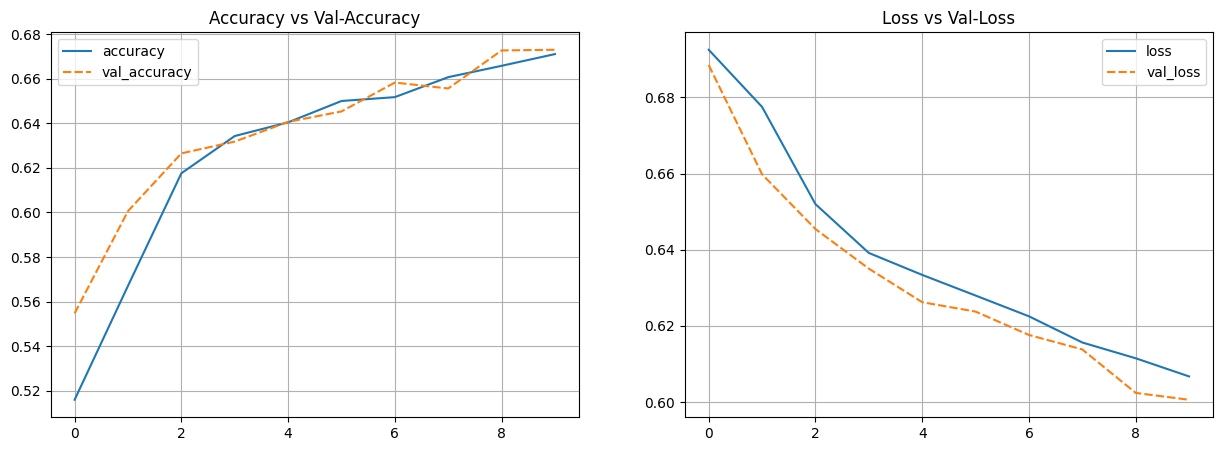

In [41]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Dari hasil train loss: 0.6113 - accuracy: 0.6661 - val_loss: 0.6131 - val_accuracy: 0.6603. Disimpulkan bahwa transfer learning menghasilkan score tidak lebih baik dari base model. Namun, transfer learning yang dilakukan membuat model menjadi good fit.

107/107 [==============================] - 3s 13ms/step


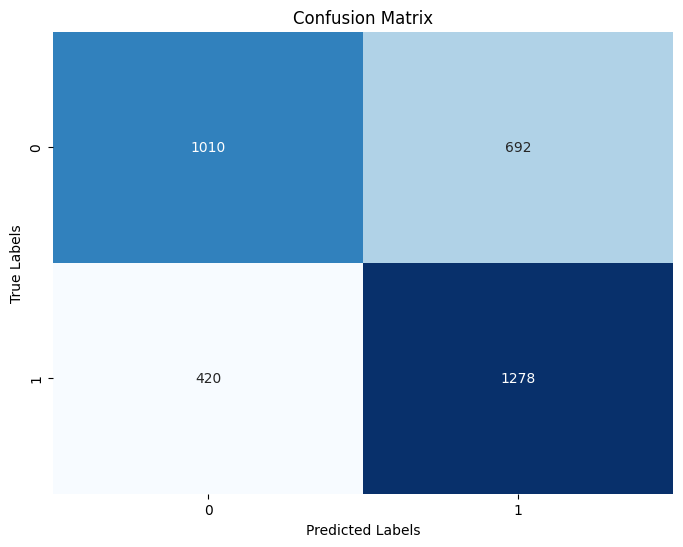

In [42]:
from sklearn.metrics import confusion_matrix
# Lakukan prediksi menggunakan model LSTM pada data validasi
predictions = model_lstm_2.predict(X_val)

# Konversi prediksi menjadi label kategori
predictions_categories = np.argmax(predictions, axis=1)

# Hitung confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_val_ohe, axis=1), predictions_categories)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Terlihat bahwa model transfer learning tidak dapat mengklasifikasikan data dengan baik. Hal ini tidak sejalan dengan tujuan dibuatnya model yang diharapkan dapat mengklasifikan data yang diterima dengan baik dan benar.

# VII. Model saving

In [69]:
# Melakukan freezing model
model_lstm_1.trainable = False

# Melakukan saving model
model_lstm_1.save('model_new.keras')

# Conclusion

- Dilakukan pembuatan 2 model (base model dan transfer learning model) yang dimana base model menggunakan embedding dan transfer model menggunakan TensorFlow Hub
- Perbedaan utama antara embedding dan TF Hub Layer adalah bahwa embedding adalah representasi numerik dari kata-kata atau frasa, sementara TF Hub Layer adalah cara untuk menggunakan kembali model-machine learning yang telah dilatih sebelumnya, termasuk embedding yang telah dilatih sebelumnya.
- Didapatkan hasil base model loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.7694 - val_accuracy: 0.8650, terjadi overfitting pada hasil train. Namun memiliki score loss dan accuracy yang baik.
- DIlakukan Transfer Learning model dengan hasil loss: 0.6113 - accuracy: 0.6661 - val_loss: 0.6131 - val_accuracy: 0.6603, disimpulkan hasil score train transfer learning model adalah good fit, namun memiliki score loss dan accuracy yang kurang baik.
- Terlihat adanya penurunan score pada Transfer Learning
- Model yang akan dilakukan pada proses selanjutnya adalah base model karena dari hasil confussion matrix terlihat dapat mengklasifikan data lebih baik dibanding transfer learning model.
- Model terbaik yang didapatkan dengan nama 'model_lstm_1' yang kemudian disave dengan nama 'best_model'
- Hanya dilakukan 10 epochs pada setiap training model, dengan alasan durasi yang terlalu lama, karena sudah memakan waktu 28 menit dibutuhkan untuk 10 epoch.